<h1>Thêm thư viện cần thiết

In [1]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.utils import column_or_1d

warnings.filterwarnings('ignore')


<h1>Nạp dữ liệu

In [2]:
df_train = pd.read_csv("../../../Dataset/ethereum_train_8_2.csv", parse_dates=True,
                       index_col=0).drop(columns=['Close', 'High', 'Low', 'Volume', 'Currency'])
df_index_train = df_train.index
df_train.head()


,Open
Date,
2020-06-01,0.23180
2020-06-02,0.24801
2020-06-03,0.23790
2020-06-04,0.24453
2020-06-05,0.24337


In [3]:
df_test = pd.read_csv("../../../Dataset/ethereum_test_8_2.csv", parse_dates=True,
                      index_col=0).drop(columns=['Close', 'High', 'Low', 'Volume', 'Currency'])
df_index_test = df_test.index
df_test.head()


,Open
Date,
2022-01-07,3.40722
2022-01-08,3.19814
2022-01-09,3.07989
2022-01-10,3.15027
2022-01-11,3.08464


# Tạo mới cột Timestamp để dự báo theo chuỗi thời gian

In [4]:
df_train['Timestamp'] = pd.to_datetime(df_train.index).astype(np.int64) / 10**9
df_train.head()


,Open,Timestamp
Date,,
2020-06-01,0.23180,1.590970e+09
2020-06-02,0.24801,1.591056e+09
2020-06-03,0.23790,1.591142e+09
2020-06-04,0.24453,1.591229e+09
2020-06-05,0.24337,1.591315e+09


In [5]:
df_test['Timestamp'] = pd.to_datetime(df_test.index).astype(np.int64) / 10**9
df_test.head()


,Open,Timestamp
Date,,
2022-01-07,3.40722,1.641514e+09
2022-01-08,3.19814,1.641600e+09
2022-01-09,3.07989,1.641686e+09
2022-01-10,3.15027,1.641773e+09
2022-01-11,3.08464,1.641859e+09


# Vẽ đồ thị

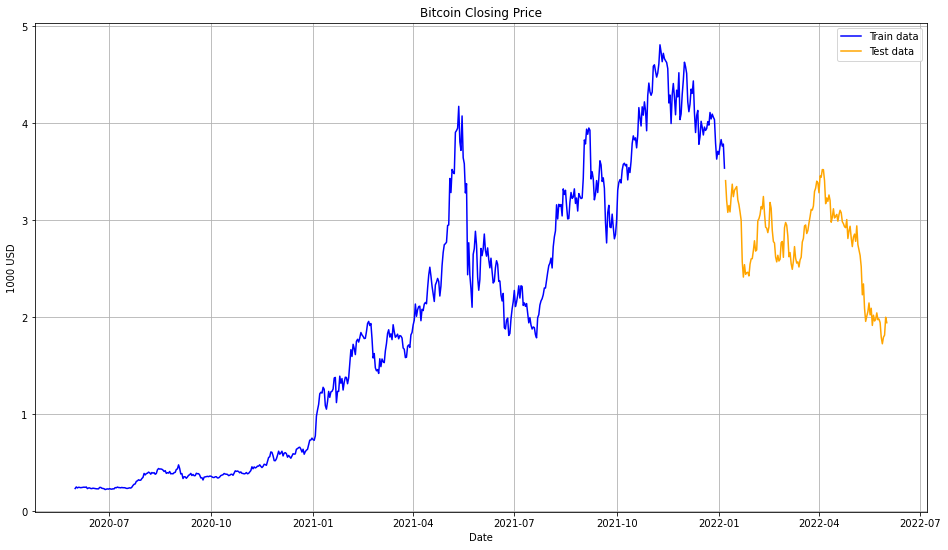

In [6]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.title("Bitcoin Closing Price")
plt.xlabel('Date')
plt.ylabel('1000 USD')
plt.plot(df_train['Open'], 'blue', label='Train data')
plt.plot(df_test['Open'], 'orange', label='Test data')
plt.legend()


# Thực hiện xây dựng mô hình SVR

## Cần chuẩn hóa dữ liệu để thuận tiện cho việc xây dựng mô hình

In [7]:
X_sc_train = StandardScaler()
y_sc_train = StandardScaler()

x_train = df_train.iloc[:, 1].values.reshape(-1, 1)
y_train = df_train.iloc[:, 0].values.reshape(-1, 1)


X_scaled_train = X_sc_train.fit_transform(x_train)
y_scaled_train = y_sc_train.fit_transform(y_train)


df_scaled_train = pd.DataFrame(index=df_index_train)
df_scaled_train['Timestamp'] = X_scaled_train
df_scaled_train['Open'] = y_scaled_train
df_scaled_train.head()


,Timestamp,Open
Date,,
2020-06-01,-1.729093,-1.184761
2020-06-02,-1.723171,-1.173312
2020-06-03,-1.717249,-1.180453
2020-06-04,-1.711328,-1.175770
2020-06-05,-1.705406,-1.176589


In [8]:
X_sc_test = StandardScaler()
y_sc_test = StandardScaler()

x_test = df_test.iloc[:, 1].values.reshape(-1, 1)
y_test = df_test.iloc[:, 0].values.reshape(-1, 1)


X_scaled_test = X_sc_test.fit_transform(x_test)
y_scaled_test = y_sc_test.fit_transform(y_test)


df_scaled_test = pd.DataFrame(index=df_index_test)
df_scaled_test['Timestamp'] = X_scaled_test
df_scaled_test['Open'] = y_scaled_test
df_scaled_test.head()


,Timestamp,Open
Date,,
2022-01-07,-1.720228,1.458878
2022-01-08,-1.696501,0.971775
2022-01-09,-1.672773,0.696283
2022-01-10,-1.649046,0.860251
2022-01-11,-1.625319,0.707350


# Xác định biến độc lập (X) và biến phụ thuộc (y)

In [9]:
X_train = df_scaled_train['Timestamp'].values.reshape(-1, 1)
y_train = df_scaled_train['Open'].values.reshape(-1, 1)

X_test = df_scaled_test['Timestamp'].values.reshape(-1, 1)
y_test = df_scaled_test['Open'].values.reshape(-1, 1)


## Hàm tạo hyperparameters

In [10]:
def para_range(minimum, maximum, step):
    para_list = np.arange(minimum, maximum, step)
    return para_list


# Hàm xuất kết quả của từng trường hợp trong GridSearch

In [11]:
def print_stats(hyperparams, stats):
    if(hyperparams[0] == 'poly'):
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}, degree={hyperparams[3]}')
    else:
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}')

    print(
        f"MAE={stats[0]:.2f} | MAPE={stats[1]:.2f} | MSE={stats[2] :.2f} | RMSE={stats[3]:.2f}")


# Tạo các giá trị cho các hyperparameters

In [12]:
kernels = ['sigmoid', 'rbf', 'poly']
Cs = para_range(0.01, 0.2, 0.1)
gammas = para_range(0.1, 5, 0.1)
degrees = para_range(1, 6, 1)


## GridSearch để tìm hyperparameters phù hợp

In [13]:
warnings.filterwarnings('ignore')

stats_df = pd.DataFrame(
    columns=['kernel', 'C', 'gamma', 'degree', 'MAE', 'MAPE', 'MSE', 'RMSE'])

# Sử dụng gird-seach để tìm hyperparameters phù hợp
for ker in kernels:
    # Nếu kernel == poly thì thực hiện chọn degree
    if(ker != 'poly'):
        for C in Cs:
            for gamma in gammas:
                rgs = SVR(kernel=ker, C=C, gamma=gamma, verbose=False)
                rgs.fit(X_train, y_train)
                pred = rgs.predict(X_test)

                # Đảo tỷ lệ thành giá trị thực
                inv_pred = y_sc_test.inverse_transform(
                    column_or_1d(pred).reshape(-1, 1))
                inv_test = y_sc_test.inverse_transform(
                    column_or_1d(y_test).reshape(-1, 1))
                    
                # Đánh giá mô hình
                mae = mean_absolute_error(inv_test, inv_pred)
                mape = mean_absolute_percentage_error(inv_test, inv_pred)
                mse = mean_squared_error(inv_test, inv_pred)
                rmse = np.sqrt(mse)

                result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': 0,
                          'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                hyperparam = [ker, C, gamma, 0]
                stats = [mae, mape, mse, rmse]
                stats_df = stats_df.append(result, ignore_index=True)
                print_stats(hyperparam, stats)
    else:
        for C in Cs:
            for gamma in gammas:
                for deg in degrees:
                    rgs = SVR(kernel=ker, C=C, gamma=gamma, degree=deg, verbose=False)
                    rgs.fit(X_train, y_train.reshape(-1, 1))
                    pred = rgs.predict(X_test)

                    # Đảo tỷ lệ thành giá trị thực
                    inv_pred = y_sc_test.inverse_transform(
                        column_or_1d(pred).reshape(-1, 1))
                    inv_test = y_sc_test.inverse_transform(
                        column_or_1d(y_test).reshape(-1, 1))

                    # Đánh giá mô hình
                    mae = mean_absolute_error(inv_test, inv_pred)
                    mape = mean_absolute_percentage_error(inv_test, inv_pred)
                    mse = mean_squared_error(inv_test, inv_pred)
                    rmse = np.sqrt(mse)

                    result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': deg,
                            'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                    hyperparam = [ker, C, gamma, deg]
                    stats = [mae, mape, mse, rmse]

                    stats_df = stats_df.append(result, ignore_index=True)

                    print_stats(hyperparam, stats)


SVR(kernel=sigmoid, C=0.01, gamma=0.1
MAE=0.42 | MAPE=0.17 | MSE=0.31 | RMSE=0.55
SVR(kernel=sigmoid, C=0.01, gamma=0.2
MAE=0.47 | MAPE=0.19 | MSE=0.39 | RMSE=0.62
SVR(kernel=sigmoid, C=0.01, gamma=0.30000000000000004
MAE=0.49 | MAPE=0.19 | MSE=0.41 | RMSE=0.64
SVR(kernel=sigmoid, C=0.01, gamma=0.4
MAE=0.50 | MAPE=0.20 | MSE=0.43 | RMSE=0.66
SVR(kernel=sigmoid, C=0.01, gamma=0.5
MAE=0.50 | MAPE=0.20 | MSE=0.44 | RMSE=0.66
SVR(kernel=sigmoid, C=0.01, gamma=0.6
MAE=0.51 | MAPE=0.20 | MSE=0.45 | RMSE=0.67
SVR(kernel=sigmoid, C=0.01, gamma=0.7000000000000001
MAE=0.51 | MAPE=0.20 | MSE=0.45 | RMSE=0.67
SVR(kernel=sigmoid, C=0.01, gamma=0.8
MAE=0.51 | MAPE=0.20 | MSE=0.44 | RMSE=0.67
SVR(kernel=sigmoid, C=0.01, gamma=0.9
MAE=0.51 | MAPE=0.20 | MSE=0.43 | RMSE=0.66
SVR(kernel=sigmoid, C=0.01, gamma=1.0
MAE=0.50 | MAPE=0.20 | MSE=0.42 | RMSE=0.65
SVR(kernel=sigmoid, C=0.01, gamma=1.1
MAE=0.49 | MAPE=0.20 | MSE=0.39 | RMSE=0.62
SVR(kernel=sigmoid, C=0.01, gamma=1.2000000000000002
MAE=0.49 | MAP

In [14]:
best_fit_model = stats_df[stats_df['MAPE']
                          == stats_df['MAPE'].min()].head(1)
best_fit_model


,kernel,C,gamma,degree,MAE,MAPE,MSE,RMSE
684,poly,0.11,4.9,4,0.337836,0.124752,0.172118,0.414871


In [15]:
kernel = str(best_fit_model['kernel'].values[0])
C = float(best_fit_model['C'])
gamma = float(best_fit_model['gamma'])
degree = int(best_fit_model['degree'])

if(kernel == 'poly'):
    rgs = SVR(kernel=kernel, C=C, gamma=gamma, degree=degree)
else:
    rgs = SVR(kernel=kernel, C=C, gamma=gamma)
    
rgs.fit(X_train, y_train.reshape(-1, 1))
pred = rgs.predict(X_test)
pred

array([-1.06388451, -1.00947114, -0.95729359, -0.90728974, -0.85939837,
       -0.81355913, -0.76971255, -0.72780002, -0.68776381, -0.64954708,
       -0.61309383, -0.57834898, -0.54525829, -0.5137684 , -0.48382685,
       -0.45538201, -0.42838317, -0.40278046, -0.37852491, -0.35556841,
       -0.33386373, -0.31336451, -0.29402527, -0.2758014 , -0.25864917,
       -0.24252572, -0.22738907, -0.2131981 , -0.19991259, -0.18749317,
       -0.17590136, -0.16509955, -0.155051  , -0.14571985, -0.13707112,
       -0.1290707 , -0.12168534, -0.11488268, -0.10863124, -0.10290041,
       -0.09766044, -0.09288248, -0.08853852, -0.08460147, -0.08104507,
       -0.07784397, -0.07497367, -0.07241055, -0.07013188, -0.0681158 ,
       -0.0663413 , -0.06478827, -0.06343747, -0.06227053, -0.06126996,
       -0.06041913, -0.05970231, -0.05910463, -0.05861209, -0.05821157,
       -0.05789082, -0.05763848, -0.05744406, -0.05729791, -0.05719132,
       -0.05711639, -0.05706613, -0.05703442, -0.05701602, -0.05

<h1>Đưa dữ liệu về miền giá trị ban đầu

In [16]:
inv_pred = y_sc_test.inverse_transform(
    column_or_1d(pred).reshape(-1, 1))
inv_test = y_sc_test.inverse_transform(
    column_or_1d(y_test).reshape(-1, 1))


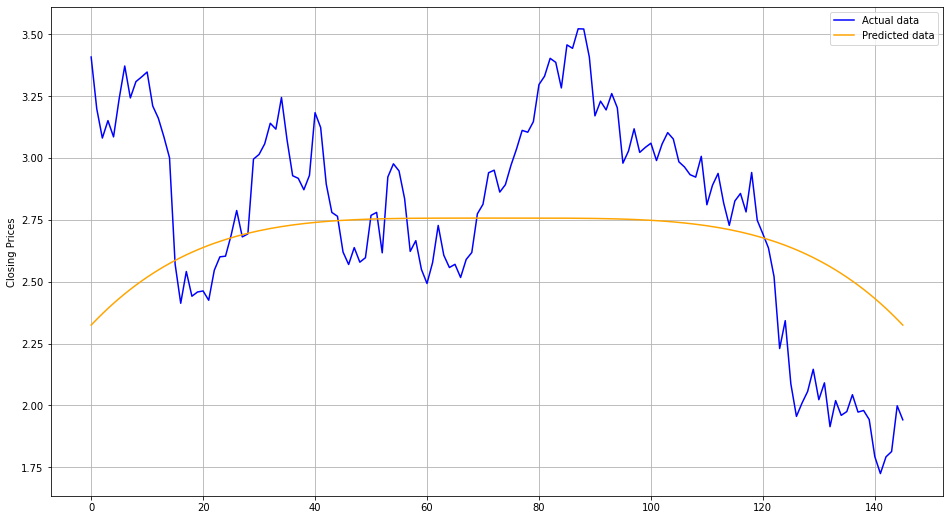

In [17]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(column_or_1d(inv_test), 'blue', label='Actual data')
plt.plot(column_or_1d(inv_pred), 'orange', label='Predicted data')
plt.legend()


# Đánh giá mô hình

In [18]:
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"R2: {r2:.2f}")


RMSE: 0.41
MAPE: 12.48%
R2: 0.07
